In [15]:
from prettytable import PrettyTable, MSWORD_FRIENDLY

import numpy as np

import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns
import pandas as pd

from importlib import reload

import testconf
import bnnc


COLOR_1 = "#5B8EFD"
COLOR_1_LIGHT = "#8566bd"

COLOR_2 = "#FFB00D"
COLOR_2_LIGHT = "#ffc57a"

COLOR_3 = "#DD217D"

COLOR_4 = "#FE6100"

In [16]:
def probplot(d, names, tag, second_color, letter):

    fig = pl.figure(constrained_layout=True)
    axes = fig.subplots(2,2)

    t = 0.7

    for i, l in enumerate(names):
        cdata, pydata, diff_mask, _ = d[f"{l}{letter}"]
        bnnc.plot.same_violin_plot(pydata, cdata, diff_mask, [axes[0][0], axes[1][0]], 1 + i*t, second_color)
        bnnc.plot.diff_violin_plot(pydata, cdata, diff_mask, [axes[0][1], axes[1][1]], 1 + i*t, second_color)

    axes[0][0].set_title("Matching Predictions")
    axes[0][1].set_title("Different Predictions")

    axes[0][0].set_xticks([])
    axes[0][1].set_xticks([])
    axes[0][1].set_ylabel("")
    axes[1][0].set_xticks([1 + i*t for i, _ in enumerate(names)], names)
    axes[1][1].set_xticks([1 + i*t for i, _ in enumerate(names)], names)
    axes[1][1].set_ylabel("")

    fig.legend(
        ["BayesianTorch", f"BnnC - {tag}"],
        bbox_to_anchor=(0.5, 1),
        loc='lower center', ncols=2,
    )

    return fig

probplot(d, testconf.Conf.hyper_model_list, "Gaussian", bnnc.plot.COLOR_1, "G").savefig("hyper_dist_gauss.pdf", bbox_inches='tight')
pl.show()

probplot(d, testconf.Conf.hyper_model_list, "Uniform", bnnc.plot.COLOR_3, "U").savefig("hyper_dist_unif.pdf", bbox_inches='tight')
pl.show()

NameError: name 'd' is not defined

In [17]:
reload(bnnc.plot)

def probplots(d, names, tag, second_color):
    fig = pl.figure(constrained_layout=True)
    axes = fig.subplots(2,2)

    t = 0.7

    for i, l in enumerate(names):
        cdata, pydata, diff_mask, _ = d[l]
        bnnc.plot.same_violin_plot(pydata, cdata, diff_mask, [axes[0][0], axes[1][0]], 1 + i*t, second_color)
        bnnc.plot.diff_violin_plot(pydata, cdata, diff_mask, [axes[0][1], axes[1][1]], 1 + i*t, second_color)

    axes[0][0].set_title("Matching Predictions")
    axes[0][1].set_title("Different Predictions")

    axes[0][0].set_xticks([])
    axes[0][1].set_xticks([])
    axes[0][1].set_ylabel("")
    axes[1][0].set_xticks([1, 1 + 1*t, 1 + 2*t], ["RESNET", "B2N2", "LENET"])
    axes[1][1].set_xticks([1, 1 + 1*t, 1 + 2*t], ["RESNET", "B2N2", "LENET"])
    axes[1][1].set_ylabel("")

    fig.legend(
        ["BayesianTorch", f"BnnC - {tag}"],
        bbox_to_anchor=(0.5, 1),
        loc='lower center', ncols=2,
    )

    fsize = fig.get_size_inches()
    fig.set_size_inches(fsize * np.array([1,1]))

    return fig

probplots(d, ["RG", "BG", "LG"], "Gaussian", bnnc.plot.COLOR_1).savefig("dist_gauss.pdf", bbox_inches='tight')
pl.show()

probplots(d, ["RU", "BU", "LU"], "Uniform", bnnc.plot.COLOR_3).savefig("dist_unif.pdf", bbox_inches='tight')
pl.show()


AttributeError: module 'bnnc' has no attribute 'plot'

In [18]:
reload(bnnc.metrics)

def load_model_predictions(modelname:str, fixed_bits:int, table):
    preds = np.load(testconf.prediction_path(modelname, "gaussian", fixed_bits))["arr_0"]
    preds = preds.transpose((1,0,2))
    _, test_data = testconf.get_data(modelname)
    targets = np.array(test_data.targets)[:len(preds)]
    gauss = bnnc.metrics.analyze_predictions(preds, targets)

    preds = np.load(testconf.prediction_path(modelname, "uniform", fixed_bits))["arr_0"]
    preds = preds.transpose((1,0,2))
    unif = bnnc.metrics.analyze_predictions(preds, targets)

    preds = np.load(testconf.baseline_path(modelname))["arr_0"]
    preds = preds.transpose((1,0,2))
    pydata = bnnc.metrics.analyze_predictions(preds, targets)

    mr_gauss, df_gauss = bnnc.metrics.match_ratio(gauss["analyzed_predictions"], pydata["analyzed_predictions"])
    mr_unif, df_unif = bnnc.metrics.match_ratio(unif["analyzed_predictions"], pydata["analyzed_predictions"])

    table.add_rows([
        [modelname, f"{100 * pydata["acc"]:.3f}", f"{100 * pydata["ece"]:.3f}", f"{100 * pydata["uce"]:.3f}", f"{100 * pydata["re"]:.3f}", f"-"],
        [f"{modelname}-gaussian", f"{100 * gauss["acc"]:.3f}", f"{100 * gauss["ece"]:.3f}", f"{100 * gauss["uce"]:.3f}", f"{100 * gauss["re"]:.3f}", f"{mr_gauss:.3f}"],
        [f"{modelname}-uniform", f"{100 * unif["acc"]:.3f}", f"{100 * unif["ece"]:.3f}", f"{100 * unif["uce"]:.3f}", f"{100 * unif["re"]:.3f}", f"{mr_unif:.3f}"]
    ])

    return {
        "python": pydata,
        "gauss": gauss,
        "unif": unif,
    }

table = PrettyTable()
table.set_style(MSWORD_FRIENDLY)
table.field_names = [f"Name", "Accuracy %", "ECE %", "UCE %", "RE %", "Match"]

data = {}

for name in testconf.Conf.model_list:
    data[name] = load_model_predictions(name, 10, table)

print(table)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
|       Name      | Accuracy % | ECE % | UCE % |  RE % | Match |
|        BO       |   90.517   | 0.881 | 2.126 | 2.725 |   -   |
|   BO-gaussian   |   90.456   | 1.559 | 2.473 | 4.113 | 0.990 |
|    BO-uniform   |   90.517   | 1.091 | 2.344 | 3.186 | 0.996 |
|        IP       |   81.444   | 0.944 | 4.341 | 2.402 |   -   |
|   IP-gaussian   |   81.561   | 0.808 | 3.929 | 2.291 | 0.985 |
|    IP-uniform   |   81.620   | 1.078 | 4.011 | 2.508 | 0.988 |
|       KSC       |   92.632   | 3.599 | 5.793 | 6.492 |   -   |
|   KSC-gaussian  |   92.479   | 3.428 | 5.469 | 5.882 | 0.993 |
|   KSC-uniform   |   92.517   | 3.614 | 5.563 | 6.166 | 0.992 |
|        PU       |   90.111   | 2.680 | 2.127 | 5.752 |   -   |
|   PU-gaussian   |   90.135   | 2.623 | 2.030 | 5.672 | 0.996 |
|    PU-uniform   |   90.139   | 2.631 | 2.028 | 5.646 | 0.996 |
|        SV       |   92.581   | 0.747 | 

In [19]:
table = PrettyTable()
table.set_style(MSWORD_FRIENDLY)
table.field_names = [f"Name", "P acc cert MAE", "P unc inn MAE"]


for name in testconf.Conf.model_list:
    pydata = data[name]["python"]
    gauss = data[name]["gauss"]
    unif = data[name]["unif"]

    qpy = bnnc.metrics.uncertainty_quality(pydata["analyzed_predictions"])
    qgauss = bnnc.metrics.uncertainty_quality(gauss["analyzed_predictions"])
    qunif = bnnc.metrics.uncertainty_quality(unif["analyzed_predictions"])

    mae_1 = np.abs(qpy["p_acc_cert"].to_numpy() - qgauss["p_acc_cert"].to_numpy()).mean()
    mae_2 = np.abs(qpy["p_unc_inn"].to_numpy() - qgauss["p_unc_inn"].to_numpy()).mean()
    

    table.add_rows([
        [f"{name}-gaussian", f"{mae_1:.5f}", f"{mae_2:.5f}"],
    ])

    mae_1 = np.abs(qpy["p_acc_cert"].to_numpy() - qunif["p_acc_cert"].to_numpy()).mean()
    mae_2 = np.abs(qpy["p_unc_inn"].to_numpy() - qunif["p_unc_inn"].to_numpy()).mean()

    table.add_rows([
        [f"{name}-uniform", f"{mae_1:.5f}", f"{mae_2:.5f}"],
    ])


print(table)


|       Name      | P acc cert MAE | P unc inn MAE |
|   BO-gaussian   |    0.00098     |    0.00446    |
|    BO-uniform   |    0.00057     |    0.00494    |
|   IP-gaussian   |    0.00117     |    0.00251    |
|    IP-uniform   |    0.00156     |    0.00369    |
|   KSC-gaussian  |    0.00121     |    0.00632    |
|   KSC-uniform   |    0.00106     |    0.00605    |
|   PU-gaussian   |    0.00023     |    0.00203    |
|    PU-uniform   |    0.00027     |    0.00220    |
|   SV-gaussian   |    0.00078     |    0.00169    |
|    SV-uniform   |    0.00043     |    0.00138    |
|  LENET-gaussian |    0.00609     |    0.01965    |
|  LENET-uniform  |    0.00487     |    0.01618    |
|  B2N2-gaussian  |    0.00775     |    0.02341    |
|   B2N2-uniform  |    0.00597     |    0.02048    |
| RESNET-gaussian |    0.00680     |    0.01810    |
|  RESNET-uniform |    0.00737     |    0.01701    |


In [20]:
# MSE
table = PrettyTable()
table.set_style(MSWORD_FRIENDLY)
table.field_names = [f"Name", "P acc cert MSE (10^-5)", "P unc inn MSE (10^-5)"]


for name in testconf.Conf.model_list:
    pydata = data[name]["python"]
    gauss = data[name]["gauss"]
    unif = data[name]["unif"]

    qpy = bnnc.metrics.uncertainty_quality(pydata["analyzed_predictions"])
    qgauss = bnnc.metrics.uncertainty_quality(gauss["analyzed_predictions"])
    qunif = bnnc.metrics.uncertainty_quality(unif["analyzed_predictions"])

    mse_1 = ((qpy["p_acc_cert"].to_numpy() - qgauss["p_acc_cert"].to_numpy())**2).mean()
    mse_2 = ((qpy["p_unc_inn"].to_numpy() - qgauss["p_unc_inn"].to_numpy())**2).mean()
    

    table.add_rows([
        [f"{name}-gaussian", f"{mse_1 * 10**5:.2f}", f"{mse_2 * 10**5:.2f}"],
    ])

    mse_1 = ((qpy["p_acc_cert"].to_numpy() - qunif["p_acc_cert"].to_numpy())**2).mean()
    mse_2 = ((qpy["p_unc_inn"].to_numpy() - qunif["p_unc_inn"].to_numpy())**2).mean()

    table.add_rows([
        [f"{name}-uniform", f"{mse_1 * 10**5:.2f}", f"{mse_2 * 10**5:.2f}"],
    ])


print(table)

|       Name      | P acc cert MSE (10^-5) | P unc inn MSE (10^-5) |
|   BO-gaussian   |          0.19          |          7.64         |
|    BO-uniform   |          0.12          |          9.11         |
|   IP-gaussian   |          0.19          |          1.89         |
|    IP-uniform   |          0.28          |          4.23         |
|   KSC-gaussian  |          0.20          |         11.26         |
|   KSC-uniform   |          0.15          |          8.11         |
|   PU-gaussian   |          0.01          |          1.02         |
|    PU-uniform   |          0.01          |          1.46         |
|   SV-gaussian   |          0.07          |          0.84         |
|    SV-uniform   |          0.02          |          0.47         |
|  LENET-gaussian |          4.78          |         65.41         |
|  LENET-uniform  |          3.02          |         43.15         |
|  B2N2-gaussian  |          7.79          |         94.10         |
|   B2N2-uniform  |          4.80 

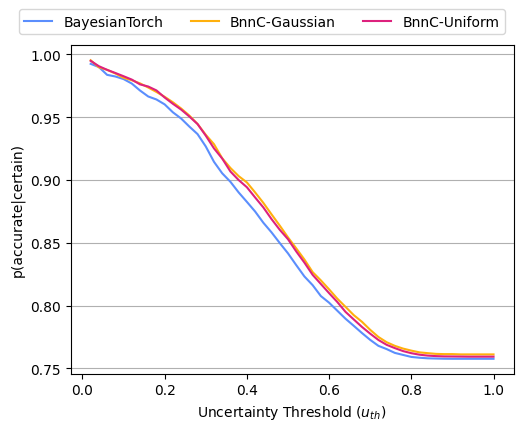

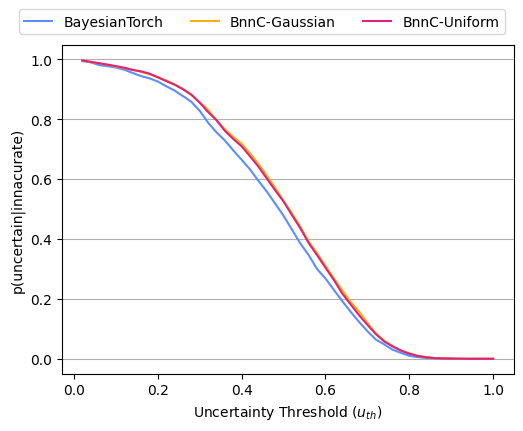

In [29]:
qpy = bnnc.metrics.uncertainty_quality(data["B2N2"]["python"]["analyzed_predictions"])
qunif = bnnc.metrics.uncertainty_quality(data["B2N2"]["unif"]["analyzed_predictions"])
qgauss = bnnc.metrics.uncertainty_quality(data["B2N2"]["gauss"]["analyzed_predictions"])

fig, ax = pl.subplots(1,1, layout='constrained')
ax.plot(qpy["uth"], qpy["p_acc_cert"], color=COLOR_1)
ax.plot(qgauss["uth"], qgauss["p_acc_cert"], color=COLOR_2)
ax.plot(qunif["uth"], qunif["p_acc_cert"], color=COLOR_3)
ax.grid(axis='y')
ax.set_ylabel("p(accurate|certain)")
ax.set_xlabel(r"Uncertainty Threshold ($u_{th}$)")

fig.legend(
    [
        mlines.Line2D([0], [0], color=COLOR_1),
        mlines.Line2D([0], [0], color=COLOR_2),
        mlines.Line2D([0], [0], color=COLOR_3)
    ], 
    [
        "BayesianTorch", "BnnC-Gaussian", "BnnC-Uniform"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=3,
)
fig.set_size_inches(fig.get_size_inches() * np.array([0.8,0.8]))
fig.savefig("Figures/b2n2_probs_acc_cer.pdf", bbox_inches='tight')
pl.show()

fig, ax = pl.subplots(1,1, layout='constrained')
ax.plot(qpy["uth"], qpy["p_unc_inn"], color=COLOR_1)
ax.plot(qgauss["uth"], qgauss["p_unc_inn"], color=COLOR_2)
ax.plot(qunif["uth"], qunif["p_unc_inn"], color=COLOR_3)
ax.grid(axis='y')
ax.set_ylabel("p(uncertain|innacurate)")
ax.set_xlabel(r"Uncertainty Threshold ($u_{th}$)")
fig.legend(
    [
        mlines.Line2D([0], [0], color=COLOR_1),
        mlines.Line2D([0], [0], color=COLOR_2),
        mlines.Line2D([0], [0], color=COLOR_3)
    ], 
    [
        "BayesianTorch", "BnnC-Gaussian", "BnnC-Uniform"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=3,
)
fig.set_size_inches(fig.get_size_inches() * np.array([0.8,0.8]))
fig.savefig("Figures/b2n2_probs_unc_inc.pdf", bbox_inches='tight')
pl.show()


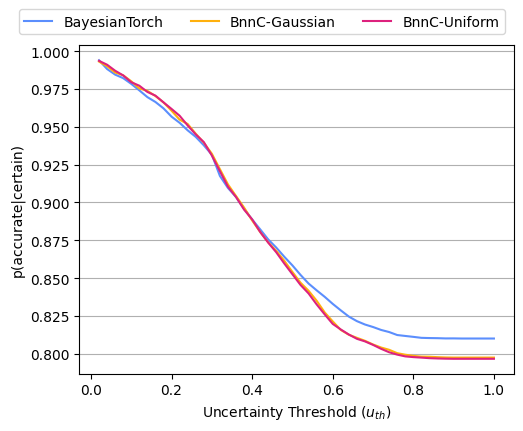

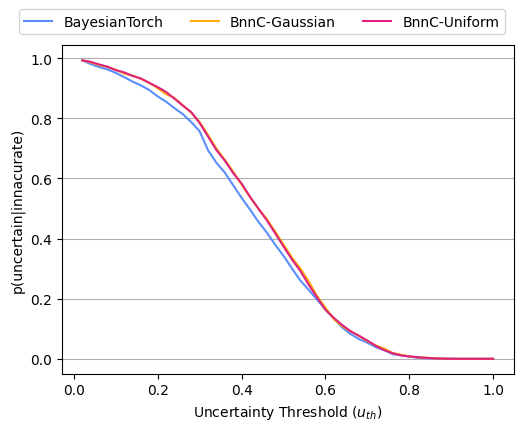

In [27]:
qpy = bnnc.metrics.uncertainty_quality(data["RESNET"]["python"]["analyzed_predictions"])
qunif = bnnc.metrics.uncertainty_quality(data["RESNET"]["unif"]["analyzed_predictions"])
qgauss = bnnc.metrics.uncertainty_quality(data["RESNET"]["gauss"]["analyzed_predictions"])

fig, ax = pl.subplots(1,1, layout='constrained')
ax.plot(qpy["uth"], qpy["p_acc_cert"], color=COLOR_1)
ax.plot(qgauss["uth"], qgauss["p_acc_cert"], color=COLOR_2)
ax.plot(qunif["uth"], qunif["p_acc_cert"], color=COLOR_3)
ax.grid(axis='y')
ax.set_ylabel("p(accurate|certain)")
ax.set_xlabel(r"Uncertainty Threshold ($u_{th}$)")
fig.legend(
    [
        mlines.Line2D([0], [0], color=COLOR_1),
        mlines.Line2D([0], [0], color=COLOR_2),
        mlines.Line2D([0], [0], color=COLOR_3)
    ], 
    [
        "BayesianTorch", "BnnC-Gaussian", "BnnC-Uniform"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=3,
)
fig.set_size_inches(fig.get_size_inches() * np.array([0.8,0.8]))
fig.savefig("Figures/resnet_probs_acc_cert.pdf", bbox_inches='tight')
pl.show()

fig, ax = pl.subplots(1,1, layout='constrained')
ax.plot(qpy["uth"], qpy["p_unc_inn"], color=COLOR_1)
ax.plot(qgauss["uth"], qgauss["p_unc_inn"], color=COLOR_2)
ax.plot(qunif["uth"], qunif["p_unc_inn"], color=COLOR_3)
ax.grid(axis='y')
ax.set_ylabel("p(uncertain|innacurate)")
ax.set_xlabel(r"Uncertainty Threshold ($u_{th}$)")
fig.legend(
    [
        mlines.Line2D([0], [0], color=COLOR_1),
        mlines.Line2D([0], [0], color=COLOR_2),
        mlines.Line2D([0], [0], color=COLOR_3)
    ], 
    [
        "BayesianTorch", "BnnC-Gaussian", "BnnC-Uniform"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=3,
)
fig.set_size_inches(fig.get_size_inches() * np.array([0.8,0.8]))
fig.savefig("Figures/resnet_probs_unc_inc.pdf", bbox_inches='tight')
pl.show()

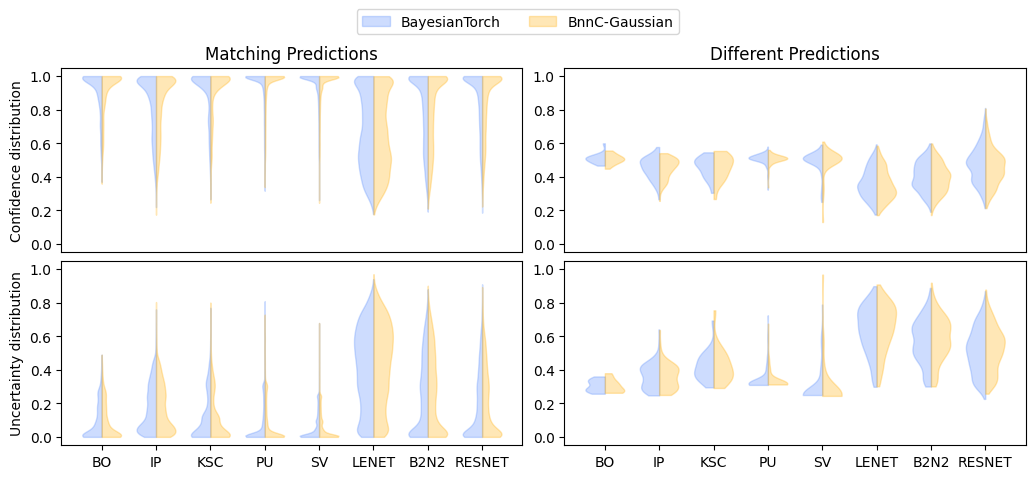

In [ ]:
fig, axes = pl.subplots(2,2, layout="constrained")
t = 0.7

pos = []
ax = axes[0][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[~df_gauss]
    gauss = gauss["confidence"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Confidence distribution")
ax.set_title("Matching Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[~df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Uncertainty distribution")
ax.set_xticks(pos, testconf.Conf.model_list)


pos = []
ax = axes[0][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[df_gauss]
    gauss = gauss["confidence"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_title("Different Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["gauss"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_2)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_xticks(pos, testconf.Conf.model_list)

fig.legend(
    [
        mpatches.Patch(color=bnnc.plot.COLOR_1, alpha=0.3),
        mpatches.Patch(color=bnnc.plot.COLOR_2, alpha=2)
    ], 
    [
        "BayesianTorch", "BnnC-Gaussian"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=2,
)

fig.set_size_inches(fig.get_size_inches() * np.array([1.6,0.9]))
fig.savefig("Figures/dist_gauss.pdf", bbox_inches="tight")

pl.show()

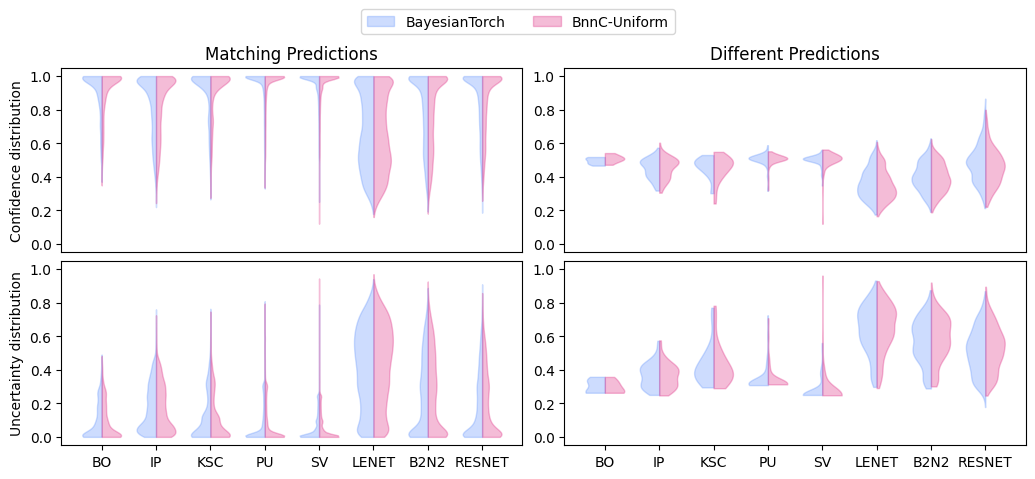

In [ ]:
fig, axes = pl.subplots(2,2, layout="constrained")
t = 0.7

pos = []
ax = axes[0][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[~df_gauss]
    gauss = gauss["confidence"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Confidence distribution")
ax.set_title("Matching Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][0]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[~df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[~df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_ylabel("Uncertainty distribution")
ax.set_xticks(pos, testconf.Conf.model_list)


pos = []
ax = axes[0][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["confidence"].to_numpy()[df_gauss]
    gauss = gauss["confidence"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_title("Different Predictions")
ax.set_xticks([])


pos = []
ax = axes[1][1]
for i, name in enumerate(testconf.Conf.model_list):
    pydata = data[name]["python"]["analyzed_predictions"]
    gauss = data[name]["unif"]["analyzed_predictions"]
    _, df_gauss = bnnc.uncertainty.match_ratio(gauss, pydata)
    pydata_gauss = pydata["uncertainty"].to_numpy()[df_gauss]
    gauss = gauss["uncertainty"].to_numpy()[df_gauss]

    p = ax.violinplot(pydata_gauss, positions=[i * 0.7], side="low", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_1)

    p = ax.violinplot(gauss, positions=[i * 0.7], side="high", showextrema=False)
    for pc in p["bodies"]:
        pc.set_color(bnnc.plot.COLOR_3)

    pos.append(i * 0.7)
ax.set_ylim(-0.05,1.05)
ax.set_xticks(pos, testconf.Conf.model_list)

fig.legend(
    [
        mpatches.Patch(color=bnnc.plot.COLOR_1, alpha=2),
        mpatches.Patch(color=bnnc.plot.COLOR_3, alpha=0.3)
    ], 
    [
        "BayesianTorch", "BnnC-Uniform"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=2,
)

fig.set_size_inches(fig.get_size_inches() * np.array([1.6,0.9]))
fig.savefig("Figures/dist_unif.pdf", bbox_inches="tight")

pl.show()

In [4]:
import yaml
import os
import pandas as pd

d = pd.DataFrame(columns=["name", "gmode", "cycles", "instructions", "stalls", "jumps_taken"])
i = 0

for name in ["LENET", "B2N2", "RESNET"]:
    for gmode in ["uniform", "custom_gn", "custom_fx", "custom_ds"]:
        with open(f"Testlog/bnn_{name}_{gmode}.yaml", "r") as f:
            prof_data =  yaml.safe_load(f)
        for counter in prof_data["counters"]:
            counter["name"] = name
            counter["gmode"] = gmode
            d.loc[i] = counter
        i += 1

for name in ["BO", "IP", "KSC", "PU", "SV"]:
    for gmode in ["uniform", "custom"]:
        with open(f"Testlog/bnn_{name}_{gmode}.yaml", "r") as f:
            prof_data =  yaml.safe_load(f)
        for counter in prof_data["counters"]:
            counter["name"] = name
            counter["gmode"] = gmode
            d.loc[i] = counter
        i += 1

print(d.to_csv())

,name,gmode,cycles,instructions,stalls,jumps_taken
0,LENET,uniform,368973898,352604726,83233,16286754
1,LENET,custom_gn,281688450,265377422,25089,16286754
2,LENET,custom_fx,232579822,216268794,25089,16286754
3,LENET,custom_ds,232615908,216189680,140289,16286754
4,B2N2,uniform,793441620,749391140,9433345,34903774
5,B2N2,custom_gn,610965935,575867327,385281,34715788
6,B2N2,custom_fx,507996187,472897579,385281,34715788
7,B2N2,custom_ds,507880497,472781889,385281,34715788
8,RESNET,uniform,320070746,303852623,2525297,13837211
9,RESNET,custom_gn,191443637,184122490,373825,6950827
10,RESNET,custom_fx,150691041,143369894,373825,6950827
11,RESNET,custom_ds,150605015,143283868,373825,6950827
12,BO,uniform,122343,116775,15,5554
13,BO,custom,66473,61102,16,5357
14,IP,uniform,162347,154979,17,7352
15,IP,custom,88336,81187,18,7133
16,KSC,uniform,142668,136176,14,6479
17,KSC,custom,77152,70845,15,6294
18,PU,uniform,90905,86769,10,4127
19,PU,custom,49871,45856,11,4006
20,SV,uniform,164975,157481,17,74

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from io import StringIO

COLOR_1 = "#5B8EFD"
COLOR_1_LIGHT = "#8566bd"

COLOR_2 = "#FFB00D"
COLOR_2_LIGHT = "#ffc57a"

COLOR_3 = "#DD217D"

COLOR_4 = "#FE6100"

def tbl(s):
    return pd.read_csv(StringIO(s), sep="\t")

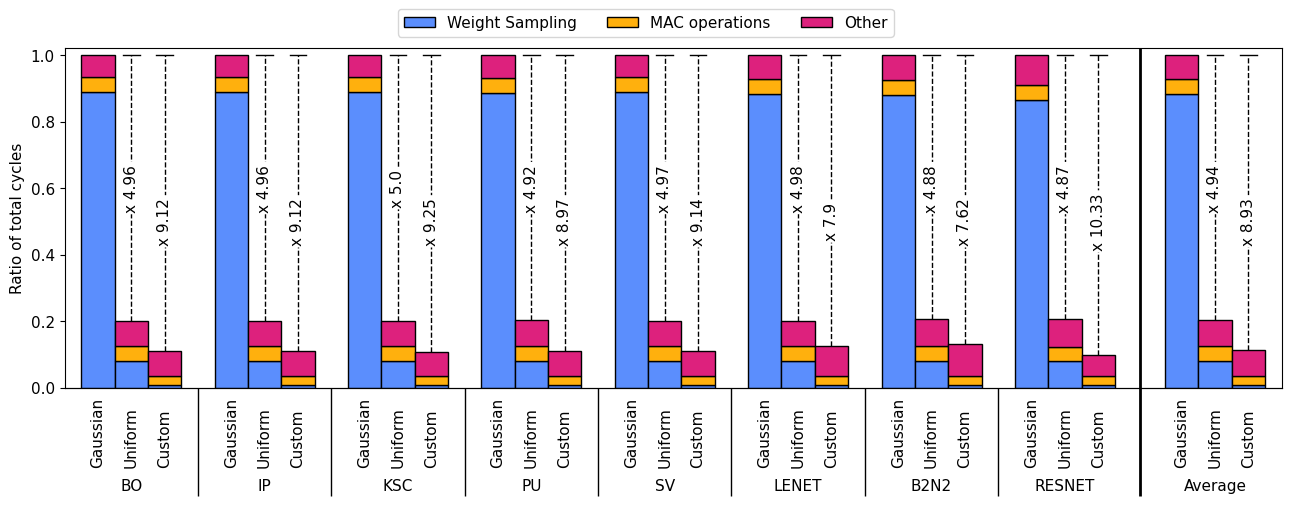

In [ ]:
dfrng = tbl("""
Model	Gaussian	Uniform	Custom
BO	0.88796	0.40004	0.08181
IP	0.88826	0.40092	0.08187
KSC	0.88991	0.40455	0.08312
PU	0.88714	0.39691	0.08039
SV	0.88855	0.40152	0.08207
LENET	0.88369	0.39993	0.07050
B2N2	0.87927	0.38976	0.06764
RESNET	0.86540	0.38278	0.09034
""")

dfkernel = tbl("""
Model	Gaussian	Uniform	Custom
BO	0.04474	0.22174	0.24542
IP	0.04478	0.22234	0.24561
KSC	0.04486	0.22433	0.24936
PU	0.04468	0.21988	0.24116
SV	0.04480	0.22268	0.24620
LENET	0.04459	0.22197	0.21149
B2N2	0.04438	0.21639	0.20292
RESNET	0.04365	0.21239	0.27101
""")

dfother = tbl("""
Model	Gaussian	Uniform	Custom
BO	0.06730	0.37822	0.67277
IP	0.06696	0.37674	0.67252
KSC	0.06523	0.37112	0.66751
PU	0.06819	0.38321	0.67845
SV	0.06665	0.37581	0.67173
LENET	0.07172	0.37810	0.71802
B2N2	0.07635	0.39385	0.72944
RESNET	0.09095	0.40484	0.63865
""")

dfscale = tbl("""
Model	Gaussian	Uniform	Custom
BO	1	0.201789	0.109639
IP	1	0.201415	0.109593
KSC	1	0.199975	0.108142
PU	1	0.203192	0.111472
SV	1	0.201181	0.109365
LENET	1	0.200874	0.126619
B2N2	1	0.205084	0.131304
RESNET	1	0.205530	0.096765
""")

dfspu = tbl("""
Model	Gauss/Uniform	Gauss/Custom
BO	4.96	9.12
IP	4.96	9.12
KSC	5.00	9.25
PU	4.92	8.97
SV	4.97	9.14
LENET	4.98	7.90
B2N2	4.88	7.62
RESNET	4.87	10.33
""")

dfavg = tbl("""
Average	Gaussian	Uniform	Custom
RNG	0.88377	0.39705	0.07972
Kernel	0.04456	0.22021	0.23915
Other	0.07167	0.38274	0.68114
Speedup	1	4.94	8.93
Scale	1	0.202362	0.111959
""")

fig, ax = pl.subplots(1,1, layout="constrained")


w = 0.1
pad = 80

x_bar = []
for i in range(8):
    x_bar.append(i*4*w)
x_bar = np.array(x_bar)


ax.set_ylim((0,1.02))
ax.set_xlim((0-2*w, x_bar[-1]+2*w + 4*w + w/2))

n = "Gaussian"
ax.bar(x_bar-w, dfrng[n] * dfscale[n], width=w, color=COLOR_1, edgecolor = "black")
ax.bar(x_bar-w, dfkernel[n] * dfscale[n], bottom=dfrng[n] * dfscale[n], width=w, color=COLOR_2, edgecolor = "black")
ax.bar(x_bar-w, dfother[n] * dfscale[n], bottom=(dfkernel[n] + dfrng[n]) * dfscale[n], width=w, color=COLOR_3, edgecolor = "black")

n = "Uniform"
ax.bar(x_bar, dfrng[n] * dfscale[n], width=w, color=COLOR_1, edgecolor = "black")
ax.bar(x_bar, dfkernel[n] * dfscale[n], bottom=dfrng[n] * dfscale[n], width=w, color=COLOR_2, edgecolor = "black")
ax.bar(x_bar, dfother[n] * dfscale[n], bottom=(dfkernel[n] + dfrng[n]) * dfscale[n], width=w, color=COLOR_3, edgecolor = "black")
# Sepeedup labels
ls = [f"x {v}" for v in dfspu["Gauss/Uniform"]]
for l, x in zip(ls, x_bar):
    ax.annotate(l, xy=(0,0), xytext=(x,0.6),  va='center', ha='center', rotation="vertical", bbox=dict(facecolor='white', edgecolor="none", boxstyle='round,pad=0.15'))
# Vertical dashed lines
m = (dfkernel[n] + dfrng[n] + dfother[n]) * dfscale[n]
for i, x in enumerate(x_bar):
    ax.plot([x, x], [m[i], 1], linestyle="--", color="black", linewidth=1)

n = "Custom"
ax.bar(x_bar+w, dfrng[n] * dfscale[n], width=w, color=COLOR_1, edgecolor = "black")
ax.bar(x_bar+w, dfkernel[n] * dfscale[n], bottom=dfrng[n] * dfscale[n], width=w, color=COLOR_2, edgecolor = "black")
ax.bar(x_bar+w, dfother[n] * dfscale[n], bottom=(dfkernel[n] + dfrng[n]) * dfscale[n], width=w, color=COLOR_3, edgecolor = "black")
# Speedup labels
ls = [f"x {v}" for v in dfspu["Gauss/Custom"]]
for l, x in zip(ls, x_bar+w):
    ax.annotate(l, xy=(0,0), xytext=(x,0.5), va='center', ha='center', rotation="vertical", bbox=dict(facecolor='white', edgecolor="none", boxstyle='round,pad=0.15'))
# Vertical dashed lines
m = (dfkernel[n] + dfrng[n] + dfother[n]) * dfscale[n]
for i, x in enumerate(x_bar+w):
    ax.plot([x, x], [m[i], 1], linestyle="--", color="black", linewidth=1)

# Horizontal markers
for x in x_bar:
    ax.plot([x - w/4, x + w/4], [1,1], color="black", linewidth=1)
    ax.plot([x + w - w/4, x + w + w/4], [1,1], color="black", linewidth=1)

# Vertical separator for AVG
x = x_bar[-1] + 2*w + w/2
pl.plot([x - w/4, x - w/4], [0, 1.02], color="black", linewidth=2)

x += 2*w
x_bar_avg = [x-w, x, x+w]

ax.bar(x_bar_avg, dfavg.transpose()[0][1:] * dfavg.transpose()[4][1:], width=w, color=COLOR_1, edgecolor = "black")
b = dfavg.transpose()[0][1:] * dfavg.transpose()[4][1:]
ax.bar(x_bar_avg, dfavg.transpose()[1][1:] * dfavg.transpose()[4][1:], bottom=b, width=w, color=COLOR_2, edgecolor = "black")
b += dfavg.transpose()[1][1:] * dfavg.transpose()[4][1:]
bars = ax.bar(x_bar_avg, dfavg.transpose()[2][1:] * dfavg.transpose()[4][1:], bottom=b, width=w, color=COLOR_3, edgecolor = "black")
b += dfavg.transpose()[2][1:] * dfavg.transpose()[4][1:]

for i, x in enumerate(x_bar_avg):
    ax.plot([x, x], [b.iloc[i], 1], linestyle="--", color="black", linewidth=1)
    if i > 0:
        ax.plot([x - w/4, x + w/4], [1,1], color="black", linewidth=1)

ls = [f"x {v}" for v in dfavg.transpose()[3][1:]]
ys = [0, 0.6, 0.5]
for i, (l, x) in enumerate(zip(ls, x_bar_avg)):
    if i > 0:
        ax.annotate(l, xy=(0,0), xytext=(x,ys[i]),  va='center', ha='center', rotation="vertical", bbox=dict(facecolor='white', edgecolor="none", boxstyle='round,pad=0.15'))

x_bar = np.array(x_bar.tolist() + [x_bar_avg[1]])
h = 0.23
for x, l in zip(x_bar - w, len(x_bar) * ["Gaussian"]):
    ax.annotate(l, xy=(0,0), xytext=(x,-h), ha='center', rotation="vertical")
for x, l in zip(x_bar, len(x_bar) * ["Uniform"]):
    ax.annotate(l, xy=(0,0), xytext=(x,-h), ha='center', rotation="vertical")
for x, l in zip(x_bar + w, len(x_bar) * ["Custom"]):
    ax.annotate(l, xy=(0,0), xytext=(x,-h), ha='center', rotation="vertical")

h += 0.08
for x, l in zip(x_bar, list(dfscale["Model"]) + ["Average"]):
    ax.annotate(l, xy=(0,0), xytext=(x,-h), ha='center')

l = 78
ax.set_xticks(x_bar[:-2] + 2*w, [])
ax.tick_params('x', length=l, width=1)
ax.set_ylabel("Ratio of total cycles")

sec = ax.secondary_xaxis(location=0)
sec.set_xticks([x_bar[-1] - 2*w - w/4], labels=[])
sec.tick_params('x', length=l, width=2)

fig.legend(
    [
        mpatches.Patch(facecolor=COLOR_1, edgecolor="black"),
        mpatches.Patch(facecolor=COLOR_2, edgecolor="black"),
        mpatches.Patch(facecolor=COLOR_3, edgecolor="black")
    ], 
    [
        "Weight Sampling", 
        "MAC operations",
        "Other"
    ],
    bbox_to_anchor=(0.5, 1),
    loc='lower center', ncols=3,
)

pl.rcParams['text.usetex'] = False
pl.rcParams.update({'font.size': 11})

fig.set_size_inches(fig.get_size_inches() * np.array([2,0.95]))
fig.savefig("Figures/speedup_result.pdf", bbox_inches='tight')


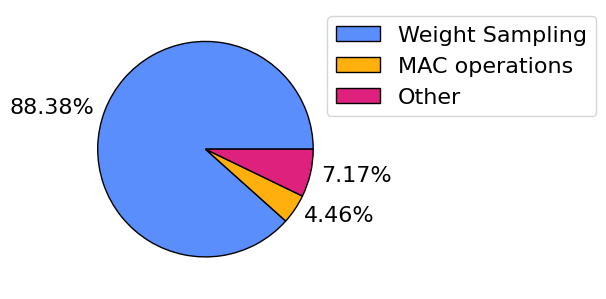

In [14]:
data = tbl("""
Average	Gaussian
RNG Ratio	0.88377
Kernel Ratio	0.04456
Other Ratio	0.07167
""")

fs = 16

fig, ax = pl.subplots(1,1, layout="constrained")
ax.pie(
    data["Gaussian"],
    colors=[COLOR_1, COLOR_2, COLOR_3],
    wedgeprops={"edgecolor":"black"},
    textprops={'fontsize': fs},
    labels=[f"{d*100:.2f}%" for d in data["Gaussian"]],
    radius=1
)

fig.legend(
    [
        mpatches.Patch(facecolor=COLOR_1, edgecolor="black"),
        mpatches.Patch(facecolor=COLOR_2, edgecolor="black"),
        mpatches.Patch(facecolor=COLOR_3, edgecolor="black")
    ], 
    [
        "Weight Sampling", 
        "MAC operations",
        "Other"
    ],
    prop={'size': fs},
    bbox_to_anchor=(0.8,1),
    loc='upper left',
)

ax.axis('equal')

fig.set_size_inches(fig.get_size_inches() * np.array([0.6,0.6]))
fig.savefig("Figures/speedup_pie.pdf", bbox_inches='tight')
pl.show()